In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import os
from tqdm import tqdm

In [11]:
# 1. 定義自訂的 Dataset
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.labels.iloc[idx, 0])
        image = Image.open(img_name).convert('L')  # 轉換為灰階
        label = int(self.labels.iloc[idx, 1])
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# 2. 定義資料轉換
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # 因為是灰階圖像，只有一個通道
])

# 3. 創建訓練和驗證數據集
full_dataset = CustomImageDataset(csv_file='aoi/train.csv', img_dir='aoi/train_images', transform=transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# 4. 定義模型
# VGG16
class CustomVGG16(nn.Module):
    def __init__(self, num_classes=6):
        super(CustomVGG16, self).__init__()
        self.model = models.vgg16(pretrained=True)
        self.model.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)  # 修改第一層以適應單通道灰階圖像
        self.model.classifier[6] = nn.Linear(4096, num_classes)  # 修改輸出層

    def forward(self, x):
        return self.model(x)
    
## ResNet18
class CustomResNet18(nn.Module):
    def __init__(self, num_classes=6):
        super(CustomResNet18, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # 修改第一層以適應單通道灰階圖像
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)  # 修改輸出層

    def forward(self, x):
        return self.model(x)

# 選擇模型
# model = CustomVGG16()
model = CustomResNet18()

# 5. 設定訓練參數
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 6. 訓練模型並紀錄 train 和 val 的 loss
# 訓練模型並紀錄 train 和 val 的 loss
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model.train()
    train_losses = []
    val_losses = []
    # 只保留val_loss最小的模型
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        running_val_loss = 0.0

        # 訓練階段
        model.train()
        train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
        for inputs, labels in train_progress:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item() * inputs.size(0)
        
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # 驗證階段
        model.eval()
        val_progress = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
        with torch.no_grad():
            for inputs, labels in val_progress:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        # 保存val_loss最小的模型
        if epoch_val_loss < best_val_loss:
            
            # 先移除舊的模型
            old_model_path = f'best_model_{best_val_loss:.2f}.pth'
            if os.path.exists(old_model_path):
                os.remove(old_model_path)
            
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), f'best_model_{epoch_val_loss:.2f}.pth')
            

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    return train_losses, val_losses

train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)


c:\ProgramData\anaconda3\envs\ml-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\envs\ml-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20, Train Loss: 1.0646, Val Loss: 0.7736


Epoch 2/20, Train Loss: 0.7509, Val Loss: 0.7776


Epoch 3/20, Train Loss: 0.5859, Val Loss: 0.3265


Epoch 4/20, Train Loss: 0.4880, Val Loss: 0.4389


Epoch 5/20, Train Loss: 0.4476, Val Loss: 0.5257


Epoch 6/20, Train Loss: 0.3626, Val Loss: 0.6675


Epoch 7/20, Train Loss: 0.3487, Val Loss: 0.2633


Epoch 8/20, Train Loss: 0.2747, Val Loss: 0.3490


Epoch 9/20, Train Loss: 0.2585, Val Loss: 0.2418


Epoch 10/20, Train Loss: 0.2149, Val Loss: 0.3136


Epoch 11/20, Train Loss: 0.2570, Val Loss: 0.2296


Epoch 12/20, Train Loss: 0.1993, Val Loss: 0.1285


Epoch 13/20, Train Loss: 0.2130, Val Loss: 0.1201


Epoch 14/20, Train Loss: 0.1535, Val Loss: 0.1386


Epoch 15/20, Train Loss: 0.1536, Val Loss: 0.1119


Epoch 16/20, Train Loss: 0.1157, Val Loss: 0.1961


Epoch 17/20, Train Loss: 0.1274, Val Loss: 0.0853


Epoch 18/20, Train Loss: 0.1450, Val Loss: 0.1159


Epoch 19/20, Train Loss: 0.1296, Val Loss: 0.0961


Epoch 20/20, Train Loss: 0.0701, Val Loss: 0.0710


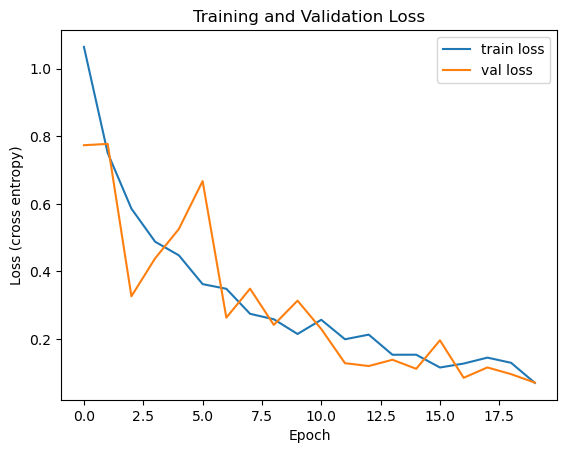

In [12]:
# 7. 繪製 loss 曲線
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss (cross entropy)')
plt.title('Training and Validation Loss')
plt.show()

## 預測測試集

In [13]:
# 8. 載入最佳模型並進行測試
# 沒有label的測試集
test_dataset = CustomImageDataset(csv_file='aoi/test.csv', img_dir='aoi/test_images', transform=transform)


In [14]:
# 測試圖片位於 aoi/test_images 目錄下
class TestImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.image_files = os.listdir(img_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.image_files[idx])
        image = Image.open(img_name).convert('L')  # 轉換為灰階
        
        if self.transform:
            image = self.transform(image)
            
        return image, self.image_files[idx]

# 定義轉換
test_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# 創建測試數據集
test_dataset = TestImageDataset(img_dir='aoi/test_images', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 載入最佳模型 <<<
best_val_loss = sorted(val_losses)[0]
model.load_state_dict(torch.load(f'best_model_{best_val_loss:.2f}.pth'))

# 模型進入評估模式
model.eval()

# 預測測試集
predictions = []
image_names = []

with torch.no_grad():
    for inputs, names in tqdm(test_loader, desc="Predicting"):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        image_names.extend(names)

# 組合結果
results = pd.DataFrame({'ID': image_names, 'Label': predictions})

# 輸出到 csv
results.to_csv('test_predictions.csv', index=False)


C:\Users\eric\AppData\Local\Temp\ipykernel_30884\4066853233.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_{best_val_loss

## 模型特徵可視化

In [18]:
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# 定義特徵提取資料集
class FeatureExtractionDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.image_files = os.listdir(img_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.image_files[idx])
        image = Image.open(img_name).convert('L')  # 轉換為灰階
        
        if self.transform:
            image = self.transform(image)
            
        return image, self.image_files[idx]

# 定義轉換
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# 創建資料集和 DataLoader
feature_dataset = FeatureExtractionDataset(img_dir='aoi/train_images', transform=transform)
feature_loader = DataLoader(feature_dataset, batch_size=32, shuffle=False)

# 提取特徵
model.eval()
features = []
labels = []

with torch.no_grad():
    for inputs, names in feature_loader:
        inputs = inputs.to(device)
        output = model.model(inputs)  # 獲取模型的特徵
        features.append(output.cpu().numpy())
        # 假設 labels 是由 train.csv 提供的對應每個圖片的標籤
        # 這裡需要一個方式來獲取當前 batch 的 labels，這取決於你的資料集定義
        

features = np.concatenate(features)


C:\Users\eric\AppData\Local\Temp\ipykernel_30884\569402785.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=features_tsne[:, 0], y=features_tsne[:, 1], hue=labels, palette='viridis')
C:\Users\eric\AppData\Local\Temp\ipykernel_30884\569402785.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Classes')


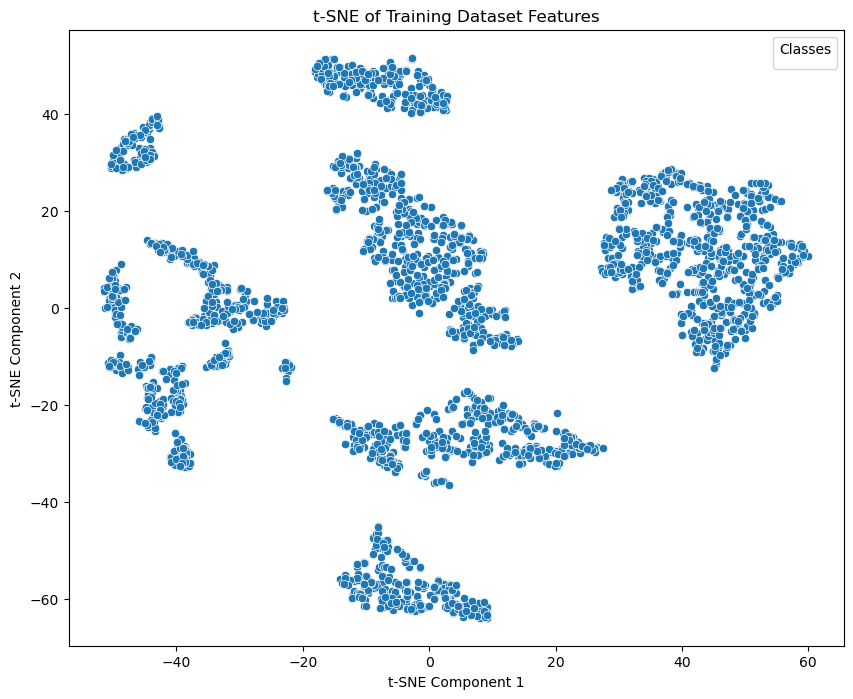

In [19]:
# 使用 t-SNE 降維
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features)

# 可視化 t-SNE 結果
plt.figure(figsize=(10, 8))
sns.scatterplot(x=features_tsne[:, 0], y=features_tsne[:, 1], hue=labels, palette='viridis')
plt.title('t-SNE of Training Dataset Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Classes')
plt.show()
